#Mount Google Drive & Load Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Load Necessary Libraries

In [2]:
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc, ConfusionMatrixDisplay
)

# Load Data (With Rib Supression)

In [3]:
with_path = '/content/drive/MyDrive/Xray_HOG_Features/hog_dataset_with_rib.pkl'
X_with, y_with = joblib.load(with_path)

# Split before scaling
X_with_train, X_with_test, y_with_train, y_with_test = train_test_split(
    X_with, y_with, test_size=0.2, stratify=y_with, random_state=42
)

# Fit only on training data
scaler_with = StandardScaler()
X_with_train_scaled = scaler_with.fit_transform(X_with_train)
X_with_test_scaled = scaler_with.transform(X_with_test)

LOGISTIC REGRESSION

In [4]:
# Train Logistic Regression on scaled training data
lr_with = LogisticRegression(max_iter=1000)
lr_with.fit(X_with_train_scaled, y_with_train)

LogisticRegression(max_iter=1000)

RANDOM FOREST

In [5]:
rf_with = RandomForestClassifier(n_estimators=100, random_state=42)
rf_with.fit(X_with_train, y_with_train)

RandomForestClassifier(random_state=42)

Parameter Tunning for SVM

In [6]:
from sklearn.utils import resample
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Utility function to get balanced samples from each class
def balanced_sample(X, y, n_samples_per_class=500):
    classes = np.unique(y)
    indices = []
    for c in classes:
        class_indices = np.where(y == c)[0]
        sampled_indices = np.random.choice(class_indices, n_samples_per_class, replace=False)
        indices.extend(sampled_indices)
    return X[indices], y[indices]

# Downsample training set to 1000 samples total (500 per class)
X_small, y_small = balanced_sample(X_with_train_scaled, y_with_train, n_samples_per_class=500)

for c in [0.1, 0.5, 1, 5]:
    print(f"\nTraining LinearSVC with C = {c} on subset")
    model = LinearSVC(C=c, random_state=42, max_iter=10000)
    model.fit(X_small, y_small)

    y_pred = model.predict(X_with_test_scaled)
    acc = accuracy_score(y_with_test, y_pred)
    print(f"Accuracy on test set: {acc:.4f}")
    print(classification_report(y_with_test, y_pred))


Training LinearSVC with C = 0.1 on subset
Accuracy on test set: 0.8971
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       700
           1       0.92      0.87      0.89       700

    accuracy                           0.90      1400
   macro avg       0.90      0.90      0.90      1400
weighted avg       0.90      0.90      0.90      1400


Training LinearSVC with C = 0.5 on subset
Accuracy on test set: 0.8971
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       700
           1       0.92      0.87      0.89       700

    accuracy                           0.90      1400
   macro avg       0.90      0.90      0.90      1400
weighted avg       0.90      0.90      0.90      1400


Training LinearSVC with C = 1 on subset
Accuracy on test set: 0.8971
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       700
           1       0.92

SIMPLE VECTOR METHOD (Linear SVM)

In [7]:
from sklearn.svm import LinearSVC
import time

# Initialize Linear SVM model
linear_svm = LinearSVC(random_state=42, max_iter=10000)

# Train the model
start_time = time.time()
linear_svm.fit(X_with_train_scaled, y_with_train)
end_time = time.time()

print(f"\nLinear SVM training completed in {(end_time - start_time):.2f} seconds")


Linear SVM training completed in 25.68 seconds


Evaluation: Accuracy, Classification Report, Confusion Matrix


Model: Logistic Regression (With Rib Suppression)
Accuracy: 0.9357142857142857
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.94       700
           1       0.93      0.94      0.94       700

    accuracy                           0.94      1400
   macro avg       0.94      0.94      0.94      1400
weighted avg       0.94      0.94      0.94      1400



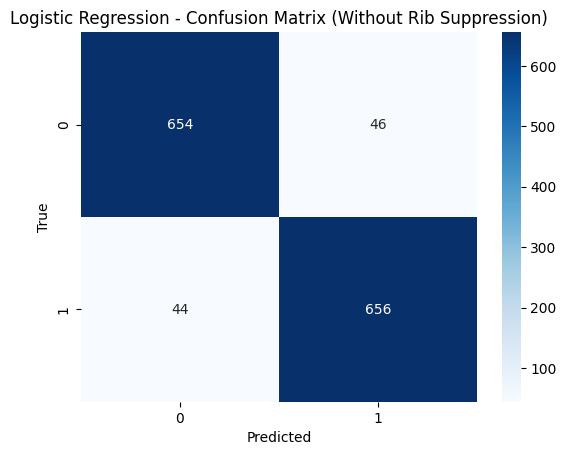


Model: SVM (Liner) (With Rib Suppression)
Accuracy: 0.9385714285714286
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.94       700
           1       0.93      0.94      0.94       700

    accuracy                           0.94      1400
   macro avg       0.94      0.94      0.94      1400
weighted avg       0.94      0.94      0.94      1400



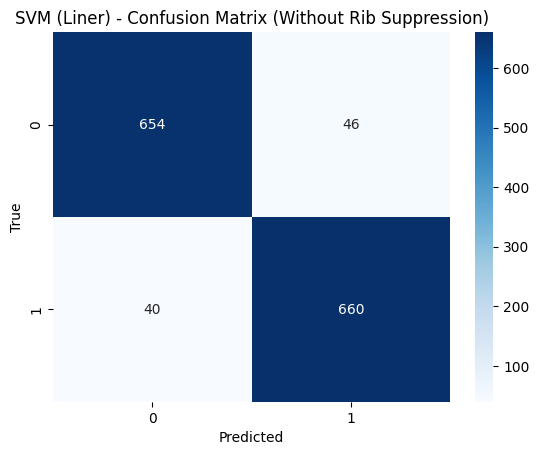


Model: Random Forest (With Rib Suppression)
Accuracy: 0.37
Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.49      0.44       700
           1       0.33      0.25      0.28       700

    accuracy                           0.37      1400
   macro avg       0.36      0.37      0.36      1400
weighted avg       0.36      0.37      0.36      1400



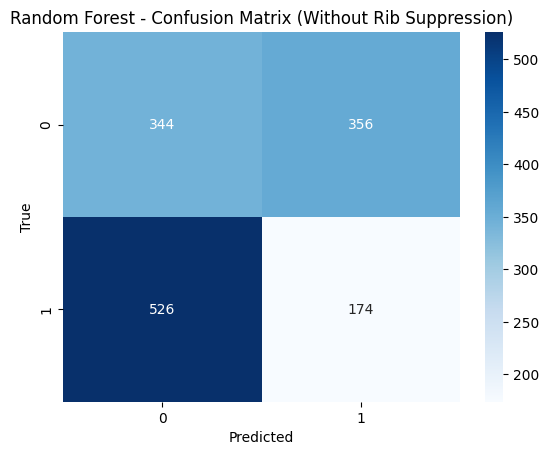

In [8]:
models_with = {
    'Logistic Regression': lr_with,
    'SVM (Liner)': linear_svm,
    'Random Forest': rf_with
}

for name, model in models_with.items():
    print(f"\nModel: {name} (With Rib Suppression)")
    y_pred = model.predict(X_with_test_scaled)
    print("Accuracy:", accuracy_score(y_with_test, y_pred))
    print("Classification Report:\n", classification_report(y_with_test, y_pred))

    cm = confusion_matrix(y_with_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix (Without Rib Suppression)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


Train vs Test Accuracy

In [9]:
print("Train vs Test Accuracy (With Rib Suppression):")
for name, model in models_with.items():
    train_acc = model.score(X_with_train_scaled, y_with_train)
    test_acc = model.score(X_with_test_scaled, y_with_test)
    print(f"{name}: Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}")


Train vs Test Accuracy (With Rib Suppression):
Logistic Regression: Train Acc = 1.0000, Test Acc = 0.9357
SVM (Liner): Train Acc = 1.0000, Test Acc = 0.9386
Random Forest: Train Acc = 0.4241, Test Acc = 0.3700


K-fold cross validation

In [13]:
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)

print("5-Fold Cross Validation (With Rib Suppression):")
for name, model in models_with.items():
    scores = cross_val_score(model, X_with_train_scaled, y_with_train, cv=kf)
    print(f"{name}: CV Accuracy = {scores.mean():.4f} ± {scores.std():.4f}")


5-Fold Cross Validation (With Rib Suppression):
Logistic Regression: CV Accuracy = 0.9359 ± 0.0075
SVM (Liner): CV Accuracy = 0.9398 ± 0.0074
Random Forest: CV Accuracy = 0.9064 ± 0.0131


Roc-curve plot

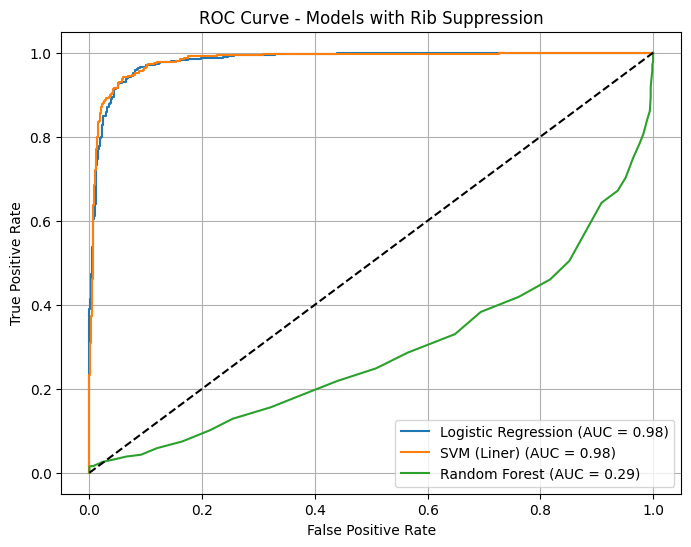

In [12]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 6))

models_with = {
    'Logistic Regression': lr_with,
    'SVM (Liner)': linear_svm,
    'Random Forest': rf_with
}

for name, model in models_with.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_with_test_scaled)[:, 1]
    else:
        y_score = model.decision_function(X_with_test_scaled)

    fpr, tpr, _ = roc_curve(y_with_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - Models with Rib Suppression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid()
plt.show()


RF with scaled data and tunned parameters


Random Forest with 100 Trees
Train Accuracy: 1.0000
Test Accuracy: 0.9157
AUC Score: 0.9756
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.92       700
           1       0.92      0.91      0.92       700

    accuracy                           0.92      1400
   macro avg       0.92      0.92      0.92      1400
weighted avg       0.92      0.92      0.92      1400

Confusion Matrix:
 [[644  56]
 [ 62 638]]


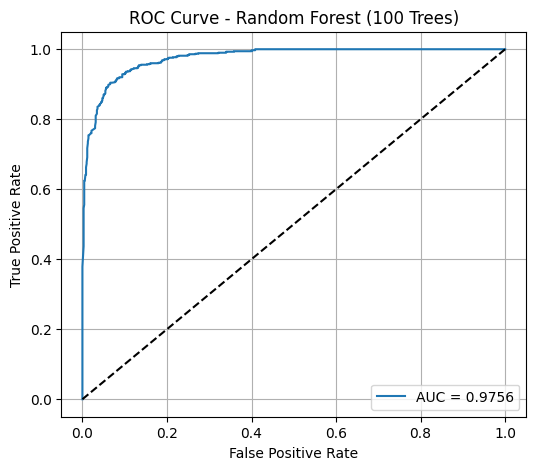

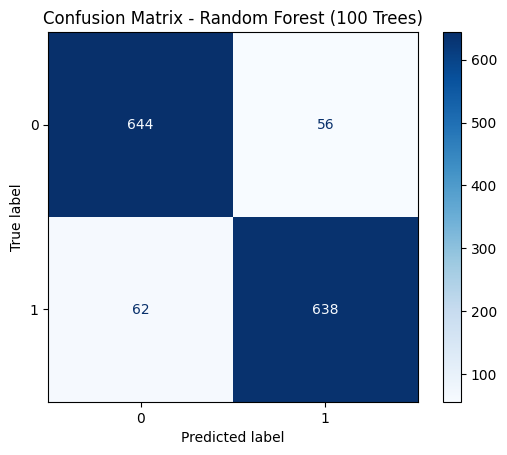


Random Forest with 200 Trees
Train Accuracy: 1.0000
Test Accuracy: 0.9186
AUC Score: 0.9768
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92       700
           1       0.93      0.91      0.92       700

    accuracy                           0.92      1400
   macro avg       0.92      0.92      0.92      1400
weighted avg       0.92      0.92      0.92      1400

Confusion Matrix:
 [[650  50]
 [ 64 636]]


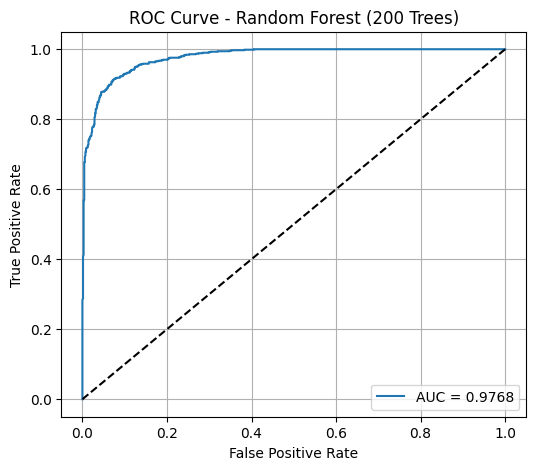

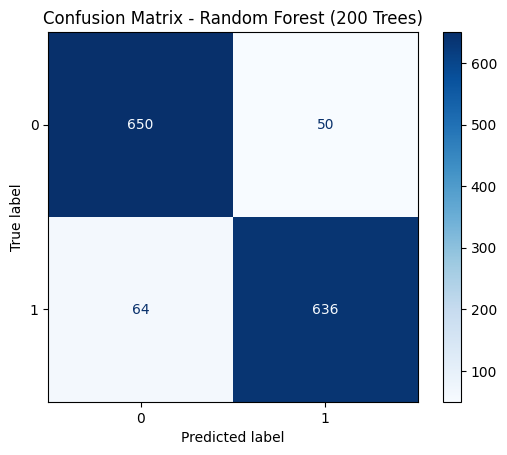


Random Forest with 300 Trees
Train Accuracy: 1.0000
Test Accuracy: 0.9221
AUC Score: 0.9779
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.92       700
           1       0.93      0.91      0.92       700

    accuracy                           0.92      1400
   macro avg       0.92      0.92      0.92      1400
weighted avg       0.92      0.92      0.92      1400

Confusion Matrix:
 [[651  49]
 [ 60 640]]


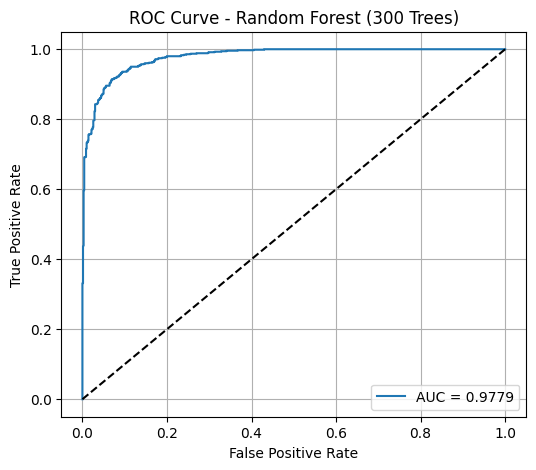

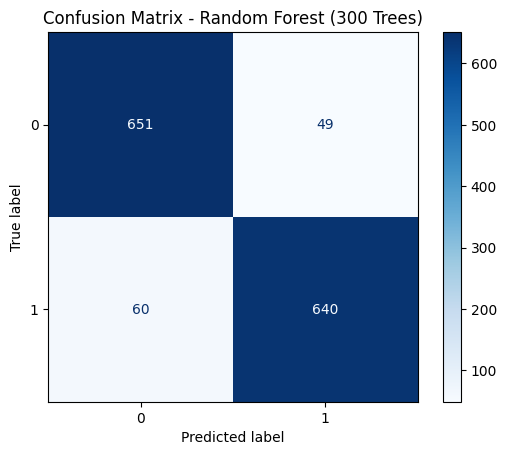

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# List of n_estimators to try
n_estimators_list = [100, 200, 300]

# Loop through each configuration
for n in n_estimators_list:
    print(f"\nRandom Forest with {n} Trees")

    # Initialize model
    rf_model = RandomForestClassifier(
        n_estimators=n,
        max_depth=30,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )

    # Train model
    rf_model.fit(X_with_train_scaled, y_with_train)

    # Predict
    train_preds = rf_model.predict(X_with_train_scaled)
    test_preds = rf_model.predict(X_with_test_scaled)

    # Accuracy scores
    train_acc = accuracy_score(y_with_train, train_preds)
    test_acc = accuracy_score(y_with_test, test_preds)

    # ROC +AUC score
    test_probs = rf_model.predict_proba(X_with_test_scaled)[:, 1]
    auc_score = roc_auc_score(y_with_test, test_probs)
    fpr, tpr, _ = roc_curve(y_with_test, test_probs)

    # Print results
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"AUC Score: {auc_score:.4f}")
    print("Classification Report:\n", classification_report(y_with_test, test_preds))
    print("Confusion Matrix:\n", confusion_matrix(y_with_test, test_preds))

    # Plot ROC Curve
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - Random Forest ({n} Trees)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Confusion Matrix
    cm = confusion_matrix(y_with_test, test_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - Random Forest ({n} Trees)")
    plt.grid(False)
    plt.show()

